 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

Скачаем обучающую и контрольную выборки.

In [2]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [3]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

# Dataset Analysis

In [4]:
print(f'Картинок в train: {len(trainset)}')

Картинок в train: 60000


In [16]:
print(f'Картинок в test: {len(testset)}')

Картинок в test: 10000


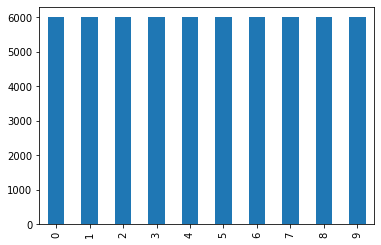

In [6]:
pd.Series(trainset.targets).value_counts().sort_index().plot(kind='bar')

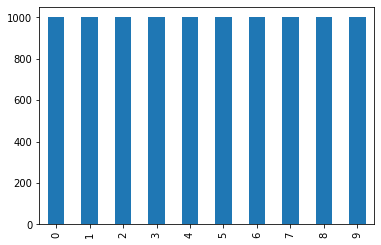

In [7]:
pd.Series(testset.targets).value_counts().sort_index().plot(kind='bar')

Распределение классов в обоих дата сетах равномерное.

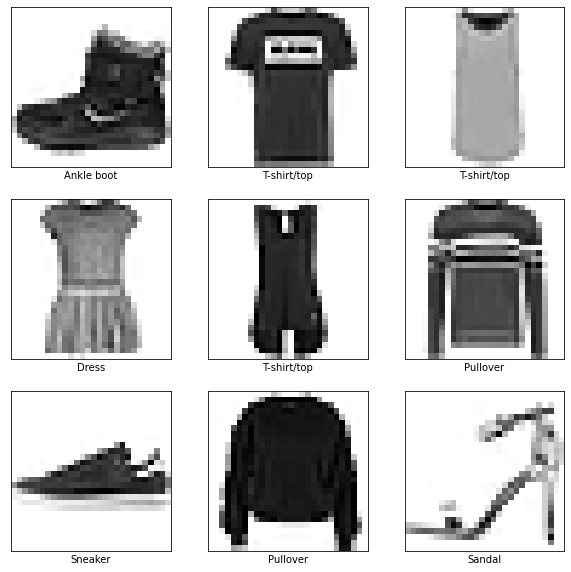

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset.train_data[i], cmap=plt.cm.binary)
    plt.xlabel(classes[trainset.targets[i]])
plt.show()

# Simple Multi-Layer Perceptron Net

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class SimpleMLPNet(nn.Module):
    def __init__(self):
        super(SimpleMLPNet, self).__init__()

        # самая обычная архитектура для MLP
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # 28 * 28 - размер развернутого тензора (из 2d картинка в 1d) без учета размера батча (-1)
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(self.fc4(x), dim=1)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

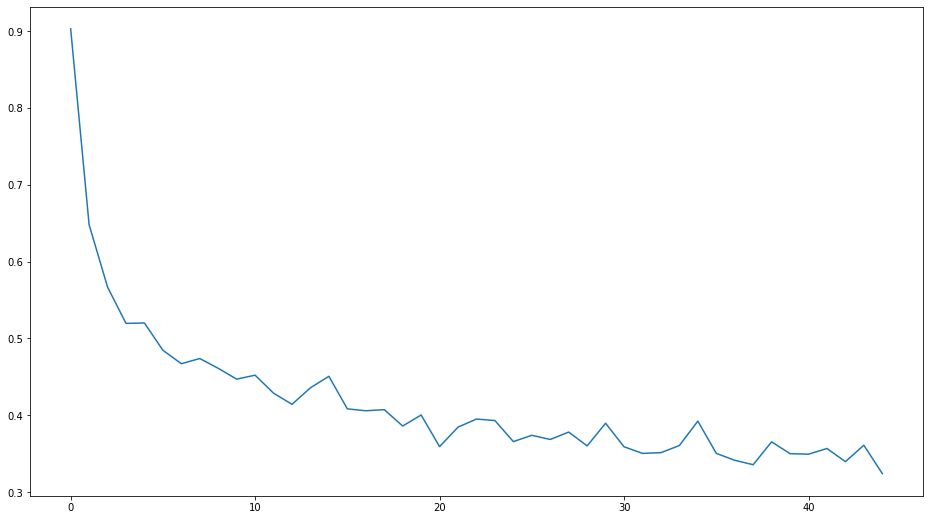

In [11]:
# создаем экземпляр класса сети на GPU
model = SimpleMLPNet().to(device)

# так как задача много классовой классификации, то функция потерь - кросс энтропия
loss_fn = nn.CrossEntropyLoss()

# за оптимизиатор возьмем Adam, он показал себя лучше SGD
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# для отрисовки графика функции потерь
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

# переменные, которые будут отвечать за значения, которые будут выводиться на графи
losses = []
loss_update_period = 1000

# кол-во эпох для обучения
epoches = 3

# обучение
for epoch in range(epoches):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % loss_update_period == (loss_update_period - 1):
            losses.append(running_loss / loss_update_period)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)

In [12]:
# пустые листы размера кол-во классов, будут отслеживать долю правильных ответов
class_correct = [0] * len(classes)
class_total = [0] * len(classes)
total_correct = 0

# предсказываем классы, при этом не меняем градиент
with torch.no_grad():
    for batch in testloader:
        X_batch, y_batch = batch
        y_pred = model(X_batch.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == y_batch.to(device)).squeeze()
        for i in range(len(y_batch)):
            label = y_batch[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total_correct += torch.sum(predicted == y_batch.to(device))

for i in range(len(classes)):
    print('Accuracy of %5s: %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nAverage Accuracy: %2d%%' % (100 * total_correct/len(testset)))

Accuracy of T-shirt/top: 85%
Accuracy of Trouser: 96%
Accuracy of Pullover: 67%
Accuracy of Dress: 83%
Accuracy of  Coat: 89%
Accuracy of Sandal: 94%
Accuracy of Shirt: 59%
Accuracy of Sneaker: 95%
Accuracy of   Bag: 97%
Accuracy of Ankle boot: 93%

Average Accuracy: 86%


# Simple Convolutional Net

In [13]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        # архитектура взята из практик + немного с обсуждений на Kaggle
        super(SimpleConvNet, self).__init__()

        # 1й сверточный блок
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn_1=nn.BatchNorm2d(32)
        self.pool_1 = nn.MaxPool2d(kernel_size=2)

        # 2й сверточный блок
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn_2=nn.BatchNorm2d(64)
        self.pool_2 = nn.MaxPool2d(kernel_size=2)

        # этап "classification", "разворачиваем" тензор, то есть умножаем размерности его пространств (кроме батча)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool_1(F.relu(self.bn_1(self.conv_1(x))))
        x = self.pool_2(F.relu(self.bn_2(self.conv_2(x))))
        x = x.view(-1, 64*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

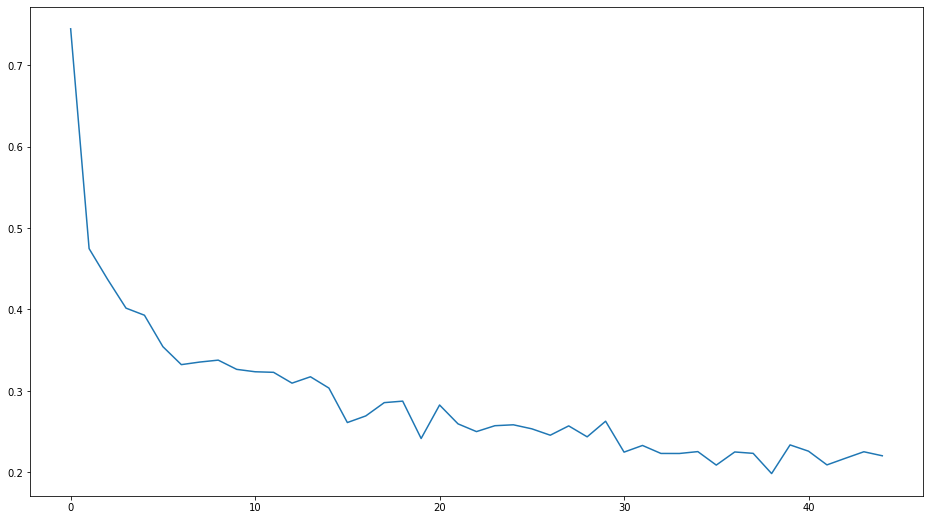

In [14]:
# делаем ровно такие же шаги как у MLP

model = SimpleConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

losses = []
loss_update_period = 1000

epoches = 3

for epoch in range(epoches):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        

        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % loss_update_period == (loss_update_period - 1):
            losses.append(running_loss / loss_update_period)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)

In [15]:
class_correct = [0] * len(classes)
class_total = [0] * len(classes)
total_correct = 0

with torch.no_grad():
    for batch in testloader:
        X_batch, y_batch = batch
        y_pred = model(X_batch.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == y_batch.to(device)).squeeze()
        for i in range(len(y_batch)):
            label = y_batch[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total_correct += torch.sum(predicted == y_batch.to(device))

for i in range(len(classes)):
    print('Accuracy of %5s: %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nAverage Accuracy: %2d%%' % (100 * total_correct/len(testset)))

Accuracy of T-shirt/top: 90%
Accuracy of Trouser: 98%
Accuracy of Pullover: 87%
Accuracy of Dress: 90%
Accuracy of  Coat: 84%
Accuracy of Sandal: 98%
Accuracy of Shirt: 71%
Accuracy of Sneaker: 95%
Accuracy of   Bag: 98%
Accuracy of Ankle boot: 96%

Average Accuracy: 91%


# Выводы
1. CNN показывает себя лучше, чем MLP. Средняя средняя accuracy по всем классам 91% против 86%;
2. CNN быстрее выходит на плато функции потерь (около 0.22), а вот MLP барахтается туда-сюда и не выходит на стабильное плато, при этом loss в среднем выше.